In [49]:
import re, string, unicodedata
import numpy as np
import pandas as pd
import langid
import time

pd.set_option('display.max_colwidth', 40)

In [50]:
import contractions
import nltk
from datetime import datetime
from matplotlib import pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laroc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Perfilamiento y entendimiento de datos

## 1. Lectura de datos

In [51]:
train_set = "fake_news_spanish.csv"
df = pd.read_csv(train_set, sep=';', encoding='utf-8')

print(df.shape)
df.head(3)

(57063, 5)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022


## 2. Entendimiento de datos

Debido a que el proyecto no contaba con un diccionario de datos se opto por desarrollar uno propio para la entrega. En este diccionario de datos se detalla lo siguiente:

| Columna | Descripción |
| - | - |
| `ID` | Se tiene el identificador del registro, sin embargo, todos los registros tienen la cadena ID. |
| `Label` | Es la etiqueta del registro; 1 si el registro es una noticia falsa, 0 de lo contrario.  |
| `Titulo` | Corresponde al titulo de la noticia. |
| `Descripcion` | Corresponde a la descripción o el cuerpo de la noticia. |
| `Fecha` | Es la fecha en la que se publico la noticia. |

In [52]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [53]:
df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC...","En política, igual que hay que negoc...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna traged...,"En una entrevista en El Punt Avui, e...",09/03/2018


Al revisar la distribución de noticias catalogadas como falsas y no falsas notamos que este sigue una buena distribución, es decir, se tiene buena cantidad de ambas clases de noticias. Cerca del 60% de los registros son noticias falsas, mientras que aproximadamente el 40% de no lo son. 

In [54]:
df["Label"].value_counts() / df.shape[0] * 100

Label
1    58.107706
0    41.892294
Name: count, dtype: float64

Se calculan las siguientes columnas para intentar hallar una relación entre estos estadisticos y las noticias falsas.

In [55]:
copy = df.copy()

copy["Count"] = [len(text) for text in copy["Descripcion"]] # Cantidad de caracteres en el registro
copy["Max"] = [max([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas larga en el registro
copy["Min"] = [min([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Longitud de la palabra mas corta en el registro
copy["Mean"] = [np.mean([len(word) for word in text.split(' ')]) for text in copy["Descripcion"] ] # Promedio de longitud de la palabra en el registro

copy.head(3)

,ID,Label,Titulo,Descripcion,Fecha,Count,Max,Min,Mean
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,218,13,1,5.083333
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023,3251,17,1,5.067164
2,ID,1,El 'Ahora o nunca' de Joan Fuster so...,El valencianismo convoca en Castelló...,25/04/2022,169,13,2,4.666667


Al realizar un análisis de los estadisticos de las noticias falsas y las que no lo son tal parece que no hay grandes diferencias entre una u otra. Por ejemplo, la media de caracteres en las noticias falsas difiera de tan solo 7 unidades de las noticias que no lo son, 240 y 247 respectivamente. Los otros estadisticos continuan con esta tendencia.

In [56]:
copy[copy["Label"] == 1][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,33158.000000,33158.000000,33158.000000
mean,240.385729,12.708245,1.171965
std,301.279710,2.102463,0.384403
min,33.000000,6.000000,0.000000
25%,169.000000,11.000000,1.000000
50%,218.000000,13.000000,1.000000
75%,257.000000,14.000000,1.000000
max,14019.000000,38.000000,3.000000


In [57]:
copy[copy["Label"] == 0][["Count", "Max", "Min"]].describe()

,Count,Max,Min
count,23905.000000,23905.000000,23905.000000
mean,247.697260,12.717005,1.156662
std,228.702697,2.151326,0.383756
min,35.000000,6.000000,0.000000
25%,176.000000,11.000000,1.000000
50%,226.000000,13.000000,1.000000
75%,278.000000,14.000000,1.000000
max,13647.000000,69.000000,3.000000


### 2.1 Calidad de datos

### 2.1.1 Unicidad

In [58]:
copy = df.copy()

copy[copy.duplicated()].shape

(445, 5)

In [59]:
copy.drop_duplicates(keep='first', inplace=True)
copy.head(2)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,01/10/2023


Al revisar los titulos y las descripciones duplicadas por separado obtenemos que hay cerca 5000 titulos duplicados y cerca de 7000 descripciones duplicadas. En los siguientes dos bloques de código se realiza un análisis de la distribución de las etiquetas, lo que nos lleva a concluir que las noticias duplicadas no tienden a ser mas falsas que las que no. Por otro lado, no es tan raro pensar en noticias con titulos duplicados, por tanto, se opta por dejar estas. Lo cual no lleva a centrar nuestra atención es las noticias con descripciones iguales. 

In [60]:
copy[copy.duplicated('Titulo')]["Label"].value_counts()

Label
0    2596
1    2417
Name: count, dtype: int64

In [61]:
copy[copy.duplicated('Descripcion')]["Label"].value_counts()

Label
0    3603
1    3377
Name: count, dtype: int64

En cuanto a las noticias con descripciones duplicadas se opta por eliminarlas del dataset. 

In [62]:
copy.drop_duplicates('Descripcion', keep='first', inplace=True)
copy.shape

(49638, 5)

### 2.1.2 Completitud

In [63]:
copy.isna().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [64]:
# Reemplazar los NaN con la primera frase de la descripcion
copy \
    .loc[copy["Titulo"].isna(), "Titulo"] = copy["Descripcion"] \
    .apply(lambda t: t.strip().split(".")[0] if isinstance(t, str) else t)

copy.isna().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### 2.1.3 Validez

En la siguiente linea de código se hace la conversión de la columna fecha a una fecha a un tipo de dato. Luego de esto, se revisa si hay valores nulos, puesto que si hay una fecha en un formato que no es apropiado se marca como `NaT`. Como se puede ver no hay fechas con formatos que no correspondan debido a lo anteriormente mencionado.

In [65]:
copy["formated_date"] = pd.to_datetime(copy["Fecha"], format="%d/%m/%Y", errors="coerce")

copy.isna().sum()

ID               0
Label            0
Titulo           0
Descripcion      0
Fecha            0
formated_date    0
dtype: int64

En la columna Label solo debe haber `0` o `1`, esto se verifica en la siguiente celda.

In [66]:
copy["Label"].value_counts()

Label
1    29361
0    20277
Name: count, dtype: int64

Se realiza un análisis de todos los titulos para comprobar si una de las palabras mas usadas en ingles se incluye en el titulo. Al realizar la transformación se obtiene que hay 37 registros con esta palabra y al revisar mas detalladamente se llega a la conclusión de que las noticias pueden tener palabras en ingles, pero en su totalidad el dataset no tiene la palabra en ingles "The", indicando la posibilidad de que este sea completamente en español. Nos quedaremos con este supuesto por facilidad. 

In [67]:
def detectar_idioma(texto):
    words = ["The", "The ", " the "]
    for word in words:
        if word in texto:
            return "unk"
    return "es"

copy["Idioma"] = copy["Titulo"].apply(detectar_idioma)

In [68]:
print(copy["Idioma"].value_counts())

Idioma
es     49601
unk       37
Name: count, dtype: int64


En la siguiente linea se revisan aquellas filas que estan marcadas con `unk`, al revisar rapidamente los titulos y las descripciones notamos que estas estan en español solo que incluyen, por ejemplo, nombres de peliculas. Para no hacer el cuaderno mas grande optamos por tomar solo los primeros 5 registros de los 37 que mencionamos. 

In [69]:
copy[copy["Idioma"] == 'unk'].head(5)

,ID,Label,Titulo,Descripcion,Fecha,formated_date,Idioma
0,ID,1,'The Guardian' va con Sánchez: 'Euro...,El diario británico publicó este pas...,02/06/2023,2023-06-02,unk
308,ID,1,La Guardia Civil incluye un 'off the...,El instituto armado se hace eco de l...,04/06/2020,2020-06-04,unk
1752,ID,1,Yolanda Díaz 'on the highway',"Bien podría ser una metáfora, bien p...",23/07/2022,2022-07-23,unk
3038,ID,1,'The New York Times' da voz a quiene...,Un reportaje refleja el descontento ...,08/04/2019,2019-04-08,unk
4281,ID,1,La revista 'The Lancet' señala que l...,El editorial de la prestigiosa revis...,17/10/2020,2020-10-17,unk


### 2.1.4 Consistencia

Se debe verificar que no tengamos noticias mayores al día de hoy, lo cual es cierto. Adicionalmente miramos las fechas de las noticias, para saber si cumplen con los estandares planteados en el diccionario

In [70]:
today = datetime.today()
copy[copy["formated_date"] > today].shape

(0, 7)

In [71]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['Año'] = df['Fecha'].dt.year 
print(df['Año'].value_counts()) 

Año
2019.0    5062
2018.0    4082
2020.0    3745
2021.0    3599
2022.0    3463
2023.0    1695
2017.0      43
2024.0      31
2016.0      20
Name: count, dtype: int64


En el siguiente codigo se verifica si para una misma descripción se cuentan con mas de dos labels diferentes, esto para evitar inconsistencias.  

In [72]:
label_conflicto = copy.groupby("Descripcion")["Label"].nunique()
print(label_conflicto[label_conflicto > 1])

Series([], Name: Label, dtype: int64)


# 3. Preparación de datos

En esta fase se hará un proceso de tres etapas:

1. Limpieza de datos
2. Tokenización
3. Normalización

## 3.1 Limpieza de datos

In [73]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
           #print("if " + new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))  # Cargar stopwords en español
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

## 3.2 Tokenización

En este punto solo es necesario 

In [74]:
#copy['Titulo'] = copy['Titulo'].apply(contractions.fix) No necesario, en español hay solo 2 contracciones
def expand_spanish_contractions(text):
    text = text.replace("al", "a el")
    return text.replace("del" ,"de el")

copy['Descripcion'] = copy['Descripcion'].apply(expand_spanish_contractions)
copy['Titulo'] = copy['Titulo'].apply(expand_spanish_contractions)

copy[['Descripcion', 'Titulo']].head(2)

,Descripcion,Titulo
0,El diario británico publicó este pas...,'The Guardian' va con Sánchez: 'Euro...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA L...,REVELAN QUE EL GOBIERNO NEGOCIO LA L...


In [75]:
copy['tokenized_desc'] = copy['Descripcion'].apply(word_tokenize)
copy['tokenized_titl'] = copy['Titulo'].apply(word_tokenize)

copy[['tokenized_desc', 'tokenized_titl']].head(3)

,tokenized_desc,tokenized_titl
0,"[El, diario, británico, publicó, est...","['The, Guardian, ', va, con, Sánchez..."
1,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO..."
2,"[El, va, elencianismo, convoca, en, ...","[El, 'Ahora, o, nunca, ', de, Joan, ..."


In [76]:
# aplica la eliminación del ruido
copy['tokenized_desc'] = copy['tokenized_desc'].apply(preprocessing)
copy['tokenized_titl'] = copy['tokenized_titl'].apply(preprocessing)

copy[['tokenized_desc', 'tokenized_titl']].head(3)

,tokenized_desc,tokenized_titl
0,"[diario, britanico, publico, pasado,...","[the, guardian, va, sanchez, europa,..."
1,"[revelan, gobierno, negocio, liberac...","[revelan, gobierno, negocio, liberac..."
2,"[va, elencianismo, convoca, castello...","[ahora, nunca, joan, fuster, estatut..."


## 3.3 Normalización

En la siguiente celda de código se realiza la normalización de las palabras utilizando `LancasterStemmer()` y `WordNetLemmatizer()`.

In [77]:
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(words):
    """Stem words in list of tokenized words"""
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

# Aplica lematización y Eliminación de Prefijos y Sufijos.
copy['normalized_desc'] = copy['tokenized_desc'].apply(stem_and_lemmatize)
copy['normalized_titl'] = copy['tokenized_titl'].apply(stem_and_lemmatize)

In [ ]:
# import pandas as pd
# import spacy
# import nltk
# from nltk.stem import SnowballStemmer

# nlp = spacy.load("es_core_news_sm")
# # Inicializar el stemmer en español
# stemmer = SnowballStemmer('spanish')

# def stem_and_lemmatize_batch(texts):
#     """Optimiza la lematización y stemming usando spaCy y Snowball en batch"""
#     docs = list(nlp.pipe(texts))  # Procesa en batch
#     results = []
#     for doc in docs:
#         stems = [stemmer.stem(token.text) for token in doc]
#         lemmas = [token.lemma_ for token in doc]
#         results.append(stems + lemmas)  # Combina ambos
#     return results

# # Aplicar el procesamiento en batch
# copy['normalized'] = stem_and_lemmatize_batch(copy['tokenized_desc'].apply(lambda x: ' '.join(x)))

## 3.4 Selección de campos

En esta parte se realiza la unión de las listas de palabras normalizadas para tener una cadena de todas las palabras.

In [78]:
copy['desc_words'] = copy['normalized_desc'].apply(lambda x: ' '.join(map(str, x)))
copy['titl_words'] = copy['normalized_titl'].apply(lambda x: ' '.join(map(str, x)))

In [79]:
copy[['desc_words', 'normalized_desc', 'titl_words', 'normalized_titl']].head(3)

,desc_words,normalized_desc,titl_words,normalized_titl
0,diario britanico publico pasado juev...,"[diario, britanico, publico, pasado,...",the guard va sanchez europ necesit a...,"[the, guard, va, sanchez, europ, nec..."
1,revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ...",revel gobierno negocio liberac mirel...,"[revel, gobierno, negocio, liberac, ..."
2,va elencianismo convoc castello fies...,"[va, elencianismo, convoc, castello,...",ahor nunc joan fust estatuto va elen...,"[ahor, nunc, joan, fust, estatuto, v..."


In [80]:
X_data, y_label = copy[['desc_words', 'titl_words']], copy['Label']
print(X_data.shape, y_label.shape)

(49638, 2) (49638,)


In [81]:
tf_idf = TfidfVectorizer()

X_words = X_data['desc_words'] + ' ' + X_data['titl_words']

X_combined = pd.concat([X_words, X_data[['desc_words', 'titl_words']]], axis=1)
X_combined.columns = ['combined', 'desc_words', 'titl_words']

X_tf_idf = tf_idf.fit_transform(X_combined['combined'])

In [82]:
X_tf_idf.shape

(49638, 66495)

TODO: Hacer un pipeline de preprocesamiento para hacer las pruebas.

# 4. Creación del pipeline de preprocesamiento

En este Pipeline se incluye (TODO: ARREGLAR ESTO)

1. Eliminar los duplicados.
2. ELIMINAR FILA SI la descripción es None (df.dropna(subset=['Descripcion'])
2. Eliminar descripciones duplicadas.
3. Para los títulos vacíos hacemos una imputación.
4. Expandir las contracciones
5. Word_tokenize
6. Preprocessing
7. Normalizar
8. Selección de campos, unirlos
9. Unir campos en uno solo
10. Devolver una matriz dispersa con las características


TODO: ARREGLAR EL PIPELINE 

In [83]:
def remove_duplicates(df):
    print('status: eliminado duplicados')
    return df.drop_duplicates(keep='first')

def remove_duplicates_desc(df):
    print('status: eliminado descripciones duplicados')
    return df.drop_duplicates('Descripcion', keep='first', inplace=False)

def empty_title(df):
    print('status: imputando titulos')
    df \
        .loc[df["Titulo"].isna(), "Titulo"] = df["Descripcion"] \
        .apply(lambda t: t.strip().split(".")[0] if isinstance(t, str) else t)
    
    return df

def expand_contractions(df):
    print('status: contracciones')
    df['Descripcion'] = df['Descripcion'].apply(expand_spanish_contractions)
    df['Titulo'] = df['Titulo'].apply(expand_spanish_contractions)
    return df

def tokenize(df):
    print('status: tokenizar')
    df['tokenized_desc'] = df['Descripcion'].apply(word_tokenize)
    df['tokenized_titl'] = df['Titulo'].apply(word_tokenize)
    return df

def clean_noise(df):
    print('status: preprocessing functions')
    df['tokenized_desc'] = df['tokenized_desc'].apply(preprocessing)
    df['tokenized_titl'] = df['tokenized_titl'].apply(preprocessing)
    return df

def normalize(df):
    print('status: normalizar')
    df['normalized_desc'] = df['tokenized_desc'].apply(stem_and_lemmatize)
    df['normalized_titl'] = df['tokenized_titl'].apply(stem_and_lemmatize)
    return df

def feature_sel(df):
    print('status: unir palabras ')
    df['desc_words'] = df['normalized_desc'].apply(lambda x: ' '.join(map(str, x)))
    df['titl_words'] = df['normalized_titl'].apply(lambda x: ' '.join(map(str, x)))
    return df

def gen_sparse_matrix(df, fit_vectorizer):
    print('status: finalizando (seleccionando caracteristicas)')
    X_data = df[['desc_words', 'titl_words']]

    X_words = X_data['desc_words'] + ' ' + X_data['titl_words']

    # X_combined = pd.concat([X_words, X_data[['desc_words', 'titl_words']]], axis=1)
    # X_combined.columns = ['combined', 'desc_words', 'titl_words']

    if fit_vectorizer:
        X_tf_idf = tf_idf.fit_transform(X_words)  # Ajustar y transformar en entrenamiento
    else:
        X_tf_idf = tf_idf.transform(X_words)

    return X_tf_idf

def transform_pipeline(df, fit_vectorizer=False):
    df = remove_duplicates(df)
    df = remove_duplicates_desc(df)
    df = empty_title(df)
    df = expand_contractions(df)
    df = tokenize(df)
    df = clean_noise(df)
    df = normalize(df)
    df = feature_sel(df)
    X_tf_idf = gen_sparse_matrix(df, fit_vectorizer)
    return X_tf_idf

In [96]:
df_test = pd.read_csv('./fake_news_test.csv', sep=';', encoding='utf-8')

# X_test = transform_pipeline(
#     df_test,
#     True
# )

# y_pred = model.predict(X_test)

# Entrenamiento de los modelos

## Código ejemplo

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tf_idf,
    y_label,
    test_size=0.3,
    random_state=42
)

In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [87]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1')

print(scores)
scores.mean()

[0.91568837 0.9064482  0.90407359 0.89936776 0.90174326]


np.float64(0.9054642355330793)

In [88]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.86      6128
           1       0.87      0.97      0.92      8764

    accuracy                           0.90     14892
   macro avg       0.91      0.88      0.89     14892
weighted avg       0.90      0.90      0.90     14892



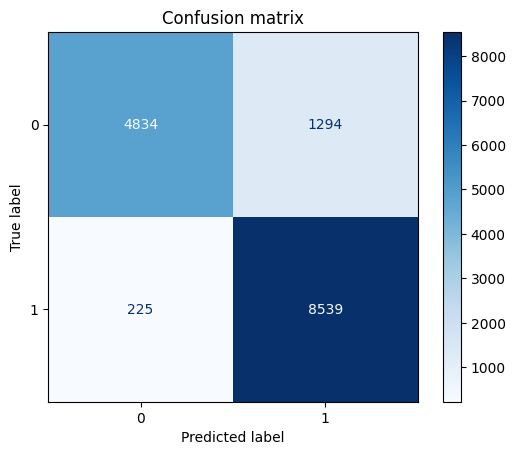

In [89]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## Modelo XGBoost

In [90]:
!pip install xgboost
from xgboost import XGBClassifier

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.8/124.9 MB 10.1 MB/s eta 0:00:13
   - -------------------------------------- 3.4/124.9 MB 8.0 MB/s eta 0:00:16
   - -------------------------------------- 4.7/124.9 MB 7.7 MB/s eta 0:00:16
   - -------------------------------------- 6.0/124.9 MB 7.4 MB/s eta 0:00:17
   -- ------------------------------------- 7.6/124.9 MB 7.2 MB/s eta 0:00:17
   -- ------------------------------------- 8.9/124.9 MB 7.2 MB/s eta 0:00:17
   --- ------------------------------------ 10.2/124.9 MB 7.1 MB/s eta 0:00:17
   --- ------------------------------------ 11.5/124.9 MB 7.0 MB/s eta 0:00:17
   ---- ----------------------------------- 13.1/124.9 MB 7.0 MB/s eta 0:00:16
   ---- ----------------------------------- 14.4/124.9 MB 7.0 MB/s eta 0:00:16
   ----- ---------------------------------- 15.7/124.9 MB 7.0 MB/s eta 0:00:16
   ----- ---------------------------------- 17.3/124.9 MB 6.9 MB/

In [91]:
model = XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [92]:
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1')

print(scores)
scores.mean()

[0.94085282 0.9314395  0.92567384 0.92013982 0.92786885]


np.float64(0.9291949656611486)

In [93]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      6128
           1       0.90      0.98      0.94      8764

    accuracy                           0.93     14892
   macro avg       0.94      0.92      0.93     14892
weighted avg       0.93      0.93      0.93     14892



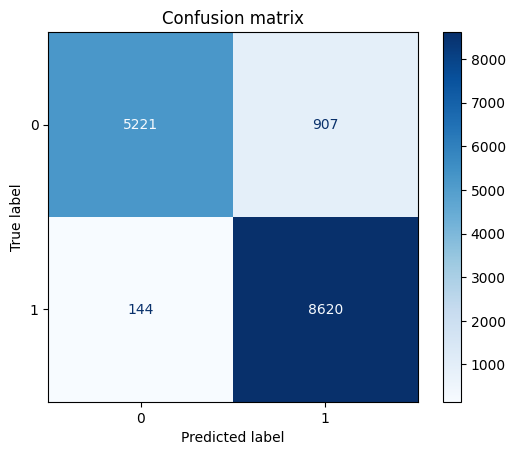

In [94]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1]
)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## Modelo RandomForest

In [99]:
!pip install scikit-learn nltk

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_label, test_size=0.2, random_state=42)

# Crear y entrenar el modelo Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
# Hacer predicciones
y_pred = modelo.predict(X_test)

# Evaluar el desempeño
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.9216357775987107

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      4098
           1       0.90      0.97      0.94      5830

    accuracy                           0.92      9928
   macro avg       0.93      0.91      0.92      9928
weighted avg       0.92      0.92      0.92      9928



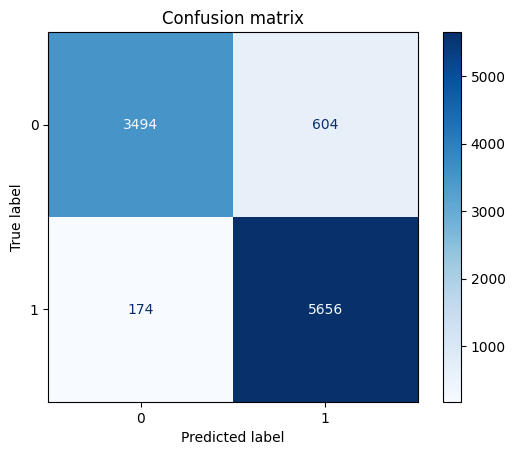

In [102]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

## Modelo Naive-Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Asegurar que estás usando la variable correcta de la vectorización
X_features = X_tf_idf  # Reemplazar con el nombre correcto si es diferente
y_target = y_label  # La variable con las etiquetas

# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Inicializar el modelo Naive Bayes
nb_model = MultinomialNB()

# Entrenar el modelo
nb_model.fit(X_train, y_train)





MultinomialNB()

In [ ]:
# Validación cruzada
scores = cross_val_score(nb_model, X_test, y_test, cv=5, scoring='f1')
# Imprimir los resultados de la validación cruzada
print("F1-scores en validación cruzada:", scores)
print("Media del F1-score:", scores.mean())


F1-scores en validación cruzada: [0.83357245 0.84286749 0.83345298 0.82679971 0.83112227]
Media del F1-score: 0.8335629801646132


In [39]:
#Predicción en el conjunto de prueba
y_pred = nb_model.predict(X_test)

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.60      0.74      4098
           1       0.78      0.98      0.87      5830

    accuracy                           0.83      9928
   macro avg       0.87      0.79      0.80      9928
weighted avg       0.85      0.83      0.81      9928



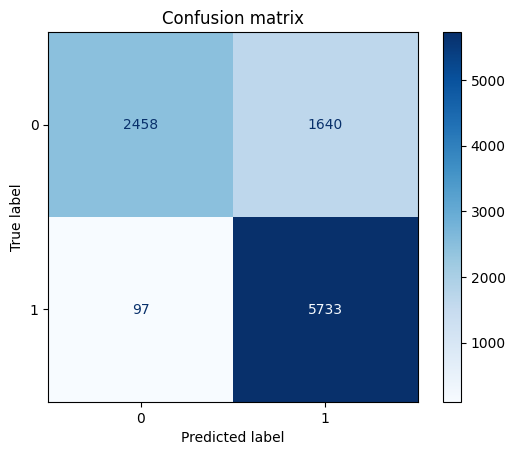

In [40]:
# Matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

# Resultados